In [15]:
# Include parent directory in sys.path to import local modules
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
import h5py
import numpy as np

### Writing to HDF5 files ###

def _save_dict_to_h5(group, data_dict):
    for key, value in data_dict.items():
        if isinstance(value, dict):
            # If it's a dictionary, create a new group
            new_group = group.create_group(key)
            _save_dict_to_h5(new_group, value) # Recursively call for nested dict
        else:
            # # Check if numpy array or standard python type
            # if not isinstance(value, np.ndarray) or not isinstance(value, (int, float, str, bool)):
            #     raise ValueError(f"Value for key '{key}' is not a numpy array.")
            # if value.ndim > 2:
            #     raise ValueError(f"Value for key '{key}' has more than 2 dimensions, which is not supported.")
            # If it's an array, create a dataset
            group.create_dataset(key, data=value)


def save_to_hdf5(my_data, filename):
    """
    Save a dictionary of numpy arrays to an HDF5 file.

    Parameters:
    my_data (dict): Dictionary where keys are dataset names and values are numpy arrays.
    file_name (str): Name of the output HDF5 file.
    """
    # 1. Open a new HDF5 file
    # 2. Create datasets for each array in the dictionary
    with h5py.File(filename, 'w') as f:
        _save_dict_to_h5(f, my_data)


### Reading from HDF5 files ###

def _load_dict_from_h5(group):
    data_dict = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            # If it's a group, recursively load it
            data_dict[key] = _load_dict_from_h5(item)
        else:
            # Otherwise, it's a dataset
            data = item[()]
            if isinstance(data, bytes):
                # Decode bytes to string if necessary
                data_dict[key] = data.decode("utf-8")
            else:
                data_dict[key] = data
    return data_dict


def load_from_hdf5(filename):
    """
    Recursively load a nested dictionary of numpy arrays from an HDF5 file.

    Parameters:
    filename (str): Name of the HDF5 file to read.
    Returns:
    dict: A dictionary where keys are dataset names and values are numpy arrays.
    """

    with h5py.File(filename, 'r') as f:

        return _load_dict_from_h5(f)
    

def load_key_from_hdf5(filename, key):
    """
    Load a specific key from an HDF5 file.

    Parameters:
    filename (str): Name of the HDF5 file to read.
    key (str): The key to load from the file.

    Returns:
    The data associated with the specified key.
    """
    with h5py.File(filename, 'r') as f:
        if key in f:
            if isinstance(f[key], h5py.Group):
                # If it's a group, recursively load it
                return _load_dict_from_h5(f[key])
            else:
                return f[key][()]
        else:
            raise KeyError(f"Key '{key}' not found in the file '{filename}'.")

## Setting the filename

In [60]:
dt = 0.5
p = 0.5
Nx = 4
Ny = 4
N = Nx*Ny
V = 3.0
b = 0.0 #2/((Nx-1)*(Ny-1))  # Magnetic field strength
num_iterations = 750
steps = 200
site_in = 1  # Site where the current is injected
drive_type = "current"  # :current, :dephasing
initial_state = "random"  # :checkerboard, :empty, :filled, :random, :custom
fermions = False  # Whether to use fermionic statistics
B = b*np.pi # Magnetic field in units of flux quantum
site_out = N  # Site where the current is extracted

if fermions:
    filename = "fermions_"
else:
    filename = "bosons_"

filename += f"{Nx}x{Ny}_dt{dt}_p{p}_b{b}_V{V}_steps{steps}_trajectories{num_iterations}_{drive_type}_{initial_state}"

---
# Plotting Density Trace

In [61]:
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
bonds = params['bonds']
bonds

array([( 2,  3), ( 3,  4), ( 5,  6), ( 6,  7), ( 7,  8), ( 9, 10),
       (10, 11), (11, 12), (13, 14), (14, 15), ( 2,  6), ( 3,  7),
       ( 4,  8), ( 5,  9), ( 6, 10), ( 7, 11), ( 8, 12), ( 9, 13),
       (10, 14), (11, 15)], dtype=[('1', '<i8'), ('2', '<i8')])

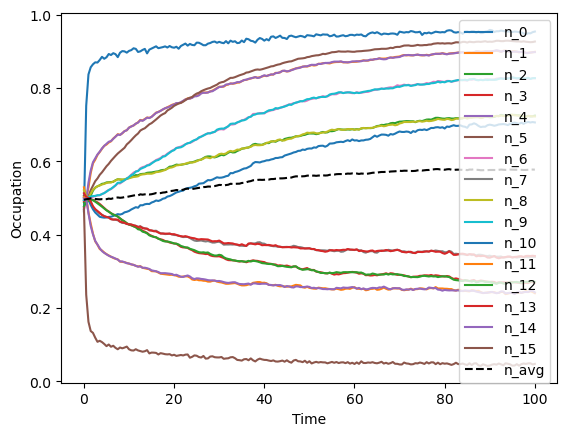

In [62]:
n_avg = load_key_from_hdf5(f"../data/{filename}.h5", "n_avg")
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny


for i in range(N):
    plt.plot(t_list, n_avg[i,:], label=f"n_{i}")
plt.plot(t_list, np.sum(n_avg, axis=0)/N, '--', c='k', label="n_avg")
plt.xlabel("Time")
plt.ylabel("Occupation")
plt.legend()

plt.savefig(f"../figures/5x5_density.pdf", bbox_inches='tight', pad_inches=0.1)


## Log-plot of densities

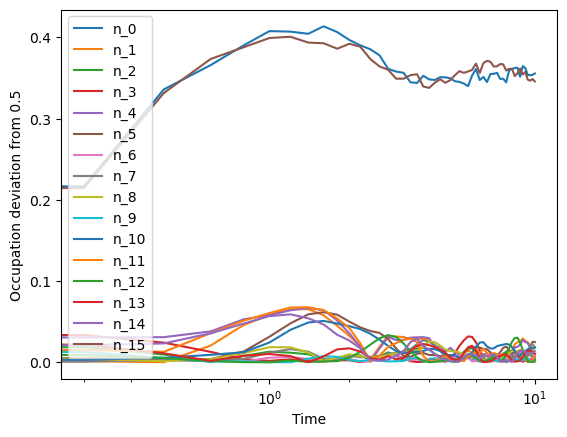

In [95]:
n_avg = load_key_from_hdf5(f"../data/{filename}.h5", "n_avg")
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny

for i in range(N):
    plt.plot(t_list, np.abs(n_avg[i,:]-0.5), label=f"n_{i}")
plt.xlabel("Time")
plt.ylabel("Occupation deviation from 0.5")
plt.legend()
plt.xscale("log")


---
# Current trace

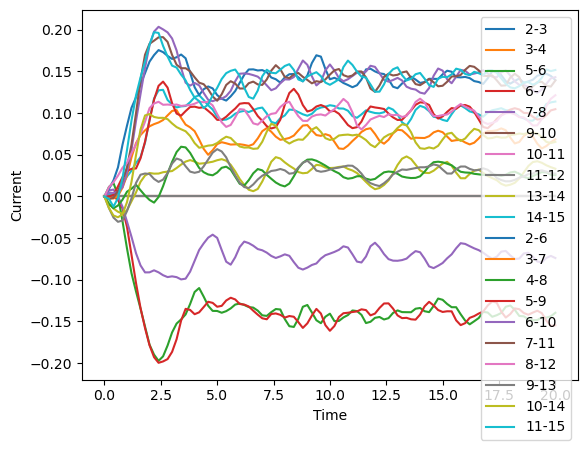

In [34]:
avg_currents = load_key_from_hdf5(f"../data/{filename}.h5", "avg_currents")
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

for i, bond in enumerate(bonds):
    plt.plot(t_list, avg_currents[i,:], label=f"{bond[0]}-{bond[1]}")
plt.xlabel("Time")
plt.ylabel("Current")
plt.legend()
plt.show()

---
# NESS Snapshot

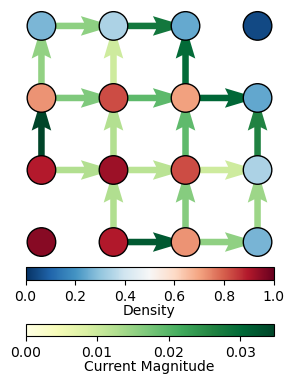

In [63]:
n_avg = load_key_from_hdf5(f"../data/{filename}.h5", "n_avg").T
avg_currents = load_key_from_hdf5(f"../data/{filename}.h5", "avg_currents").T
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

plotting_threshold = 0.0  # Threshold for plotting currents
marker_size = 750 * (3/Nx)**2  # Size of the markers for the density plot
arrow_width = 0.035 * 3/Nx  # Width of the arrows in the quiver plot

# single line definition of empty lists for X, Y, U, V, C
X = []; Y = []; U = []; V = []; C = []
for i, bond in enumerate(bonds):
    # convert back from n to x,y coordinates
    x1, y1 = (bond[0]-1) % Nx, (bond[0]-1) // Nx
    x2, y2 = (bond[1]-1) % Nx, (bond[1]-1) // Nx

    if np.abs(avg_currents[-1,i]) > plotting_threshold*np.abs(avg_currents[-1,:]).max():
        C.append(np.abs(avg_currents[-1,i]))

        if np.real(avg_currents[-1,i]) > 0:
            X.append(x1)
            Y.append(y1)
            U.append(x2-x1)
            V.append(y2-y1)
        else:
            X.append(x2)
            Y.append(y2)
            U.append(x1-x2)
            V.append(y1-y2)

fig, ax = plt.subplots()

p1 = ax.quiver(X, Y, U, V, C, cmap="YlGn", angles='xy', scale_units='xy', scale=1, width=arrow_width)
p1.set_clim(0, np.max(C))
cb1 = plt.colorbar(p1, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb1.set_label('Current Magnitude', labelpad=0)

X = []; Y = []; C = []
for x in range(Nx):
    for y in range(Ny):
        n = x % Nx + y*Nx
        X.append(x)
        Y.append(y)
        C.append(n_avg[-1,n])

p2 = ax.scatter(X, Y, c=C, cmap="RdBu_r", s=marker_size, edgecolors= "black", vmin=0, vmax=1)
cb2 = plt.colorbar(p2, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb2.set_label('Density', labelpad=0)

# Add automatic padding to prevent cutoff
ax.margins(0.1 * 3/Nx)  # Add padding around the data
# Alternatively, you could use: ax.set_xlim(-0.5, Nx-0.5); ax.set_ylim(-0.5, Ny-0.5)

ax.set_axis_off()
ax.set_aspect('equal')

# Save to file as pdf
plt.savefig(f"../figures/5x5_snapshot.pdf", bbox_inches='tight', pad_inches=0.1)



# Time-Averaged Snapshot

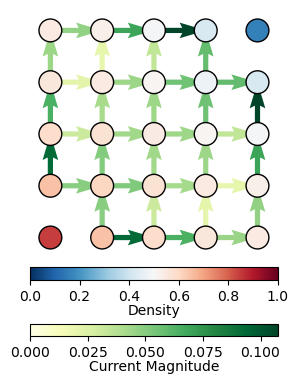

In [14]:
n_avg = load_key_from_hdf5(f"../data/{filename}.h5", "n_avg").T
avg_currents = load_key_from_hdf5(f"../data/{filename}.h5", "avg_currents").T
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

plotting_threshold = 0.0  # Threshold for plotting currents
marker_size = 750 * (3/Nx)**2  # Size of the markers for the density plot
arrow_width = 0.035 * 3/Nx  # Width of the arrows in the quiver plot


time_averaged_currents = np.mean(avg_currents[7*steps//8:-1], axis=0)
time_averaged_n = np.mean(n_avg[7*steps//8:-1], axis=0)

# single line definition of empty lists for X, Y, U, V, C
X = []; Y = []; U = []; V = []; C = []
for i, bond in enumerate(bonds):
    # convert back from n to x,y coordinates
    x1, y1 = (bond[0]-1) % Nx, (bond[0]-1) // Nx
    x2, y2 = (bond[1]-1) % Nx, (bond[1]-1) // Nx

    if np.abs(time_averaged_currents[i]) > plotting_threshold*np.abs(time_averaged_currents).max():
        C.append(np.abs(time_averaged_currents[i]))

        if np.real(time_averaged_currents[i]) > 0:
            X.append(x1)
            Y.append(y1)
            U.append(x2-x1)
            V.append(y2-y1)
        else:
            X.append(x2)
            Y.append(y2)
            U.append(x1-x2)
            V.append(y1-y2)

fig,ax = plt.subplots()

p1 = ax.quiver(X, Y, U, V, C, cmap="YlGn", angles='xy', scale_units='xy', scale=1, width=arrow_width)
p1.set_clim(0, np.max(C))
cb1 = plt.colorbar(p1, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb1.set_label('Current Magnitude', labelpad=0)

X = []; Y = []; C = []
for x in range(Nx):
    for y in range(Ny):
        n = x % Nx + y*Nx
        X.append(x)
        Y.append(y)
        C.append(time_averaged_n[n])


p2 = ax.scatter(X, Y, c=C, cmap="RdBu_r", s=marker_size, edgecolors= "black", vmin=0, vmax=1)
cb2 = plt.colorbar(p2, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb2.set_label('Density', labelpad=0)

# Add automatic padding to prevent cutoff
ax.margins(0.1)  # Add padding around the data
# Alternatively, you could use: ax.set_xlim(-0.5, Nx-0.5); ax.set_ylim(-0.5, Ny-0.5)

ax.set_axis_off()
ax.set_aspect('equal')
plt.show()

# Density Correlation matrix

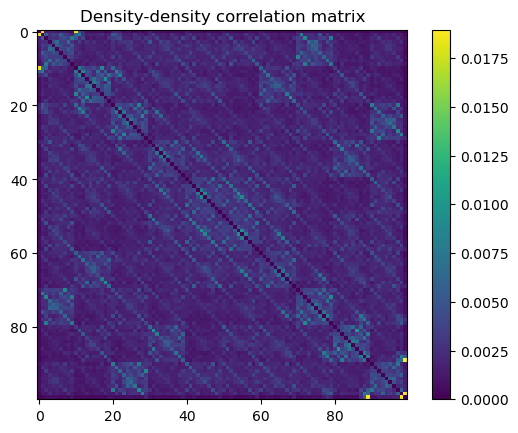

In [120]:
avg_dd_correlations = load_key_from_hdf5(f"../data/{filename}.h5", "avg_dd_correlations")

plt.imshow(np.abs(avg_dd_correlations - np.diag(np.diag(avg_dd_correlations))), cmap="viridis", vmin=0)
plt.colorbar()
plt.title("Density-density correlation matrix")
plt.show()

In [121]:
K_avg = load_key_from_hdf5(f"../data/{filename}.h5", "K_avg")

In [127]:
K_avg[:, 2]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])